# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
SOLVER = 'liblinear' 
PENALTY = "l1"


!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt
!python3 -m pip install prettytable

import os
import sys
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict

import sklearn.exceptions
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 

import collections
import matplotlib.pyplot as plt
import pylab as pl


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')

from tqdm.notebook import tqdm
import collections
from prettytable import PrettyTable


print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:

verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:
cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0


# GloVE

## Download and Load GloVe

In [7]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


## GloVe Train & Predict

In [8]:
cls = 'CR-00-00-00-00'



# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Checkpoint1 - Data Read Complete



Mean Train Word Hit Rate(\%) 99.58181372991224



Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.875
precision: [0.9924812  0.51162791]
recall: [0.8627451  0.95652174]
fscore: [0.92307692 0.66666667]
support: [153  23]


## GloVE + Logistic Regression on CR-00-00-00-00

In [9]:

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)
    
    
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000)
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)
        prob = classifier[cls].predict_proba(X_test)[:,1]
        
        

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            probs[x] = prob[i]
            i += 1
            
        #print(preds)

        n_iter += 1
        
    custom_logloss = np.round(log_loss(Y, probs), 4)
    custom_brierloss = np.round(brier_score_loss(Y, probs), 4)
    print('logloss:', custom_logloss)
    print('brierloss: ',custom_brierloss)
    
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1], custom_logloss, custom_brierloss)



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created
logloss: 0.3465
brierloss:  0.1049


(0.8582, 0.5717, 0.8444, 0.6818, 302, 0.3465, 0.1049)

## GloVe GridSearch


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679



C: 32.0 0.3068



C: 16.0 0.3038



C: 8.0 0.3018



C: 4.0 0.3047



C: 2.0 0.3168



C: 1.0 0.3465
(0.8755, 0.6126, 0.8377, 0.7077, 302, 0.3018, 0.091, 8.0, 1679)


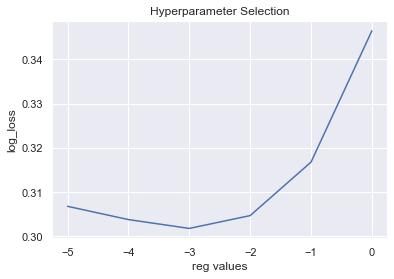

8.0


In [10]:
verbose = False
numdoc = defaultdict()
classifier = defaultdict()

    
def predict_by_class_glove_grid(dfset: defaultdict,cls: str) -> float:
    global PENALTY, SOLVER
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))
    kfold = KFold(n_splits=10)
    print('data set size', len(X_glove))
    numdoc[cls] = len(X_glove)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)

    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    best_c = 0
    
    best_logloss = 1
    best_brierloss = 1
    
    model = None


    for reg in range(-5, 1):
        
        c = 1.0/2.0**reg

        model = LogisticRegression(penalty=PENALTY, solver=SOLVER, class_weight='balanced', max_iter=2000, C = c)
        
        for train_index, test_index in tqdm(kfold.split(X_glove, Y)):
            X_train, X_test = X_glove[train_index], X_glove[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            out = model.predict(X_test)
            prob = model.predict_proba(X_test)[:,1]

            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

            
        custom_logloss = np.round(log_loss(Y, probs), 4)
        custom_brierloss = np.round(brier_score_loss(Y, probs), 4)  
        
        c_list.append(reg)
        loss_list.append(custom_logloss)
        print('C:', c, end=' ')
        print(custom_logloss)

        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall:   tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)

#        if best_recall < recall[1]:
        if best_logloss > custom_logloss:
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            best_c = c
        if best_brierloss > custom_brierloss:
            best_brierloss = custom_brierloss
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support, best_logloss, best_brierloss, best_c, numdoc[cls])

c_list = []
loss_list = []

cls = 'CR-00-00-00-00'
print(predict_by_class_glove_grid(dfset, cls))



# plotting the points  
plt.plot(range(-5,1), loss_list)  
plt.xlabel('reg values') 
plt.ylabel('log_loss') 
plt.title('Hyperparameter Selection') 
plt.show() 
print(classifier[cls].C)

# Entire Data 

## Build Models and Calculating Accuracies

In [11]:


class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    ret = predict_by_class_glove_grid(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')



------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848



C: 32.0 0.2104



C: 16.0 0.203



C: 8.0 0.204



C: 4.0 0.2172



C: 2.0 0.2468



C: 1.0 0.2951
statistics (0.9356, 0.1349, 0.6296, 0.2222, 27, 0.203, 0.0465, 16.0, 1848)



------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590



C: 32.0 0.1749



C: 16.0 0.1658



C: 8.0 0.1605



C: 4.0 0.1664



C: 2.0 0.1852



C: 1.0 0.2169
statistics (0.944, 0.5122, 0.9032, 0.6537, 93, 0.1605, 0.0448, 8.0, 1590)



------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164



C: 32.0 0.3152



C: 16.0 0.313



C: 8.0 0.3084



C: 4.0 0.3099



C: 2.0 0.3284



C: 1.0 0.3644
statistics (0.8849, 0.4278, 0.783, 0.5533, 106, 0.3084, 0.0879, 8.0, 1164)



------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679



C: 32.0 0.3068



C: 16.0 0.3038



C: 8.0 0.3018



C: 4.0 0.3047



C: 2.0 0.3168



C: 1.0 0.3465
statistics (0.8755, 0.6126, 0.8377, 0.7077, 302, 0.3018, 0.091, 8.0, 1679)



------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393



C: 32.0 0.2284



C: 16.0 0.2167



C: 8.0 0.2167



C: 4.0 0.2402



C: 2.0 0.2794



C: 1.0 0.3339
statistics (0.9368, 0.025, 0.1667, 0.0435, 12, 0.2167, 0.0433, 16.0, 1393)



------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402



C: 32.0 0.2694



C: 16.0 0.2541



C: 8.0 0.261



C: 4.0 0.2899



C: 2.0 0.331



C: 1.0 0.3722
statistics (0.9244, 0.0105, 0.0769, 0.0185, 13, 0.2541, 0.0547, 16.0, 1402)



------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404



C: 32.0 0.1415



C: 16.0 0.13



C: 8.0 0.1382



C: 4.0 0.1631



C: 2.0 0.2074



C: 1.0 0.2744
statistics (0.9594, 0.0577, 0.2727, 0.0952, 11, 0.13, 0.0295, 16.0, 1404)



------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969



C: 32.0 0.1641



C: 16.0 0.152



C: 8.0 0.1543



C: 4.0 0.1743



C: 2.0 0.2115



C: 1.0 0.2691
statistics (0.9599, 0.0278, 0.1818, 0.0482, 11, 0.152, 0.0293, 16.0, 1969)



------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813



C: 32.0 0.125



C: 16.0 0.1214



C: 8.0 0.1271



C: 4.0 0.1442



C: 2.0 0.1752



C: 1.0 0.2142
statistics (0.968, 0.2424, 0.6667, 0.3556, 24, 0.1214, 0.024, 16.0, 1813)



------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944



C: 32.0 0.2261



C: 16.0 0.2166



C: 8.0 0.2111



C: 4.0 0.216



C: 2.0 0.2369



C: 1.0 0.2675
statistics (0.9126, 0.2909, 0.8205, 0.4295, 78, 0.2111, 0.0611, 8.0, 1944)



------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876



C: 32.0 0.0931



C: 16.0 0.0903



C: 8.0 0.1003



C: 4.0 0.117



C: 2.0 0.1445



C: 1.0 0.1872
statistics (0.9744, 0.0476, 0.2, 0.0769, 10, 0.0903, 0.0188, 16.0, 1876)



------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992



C: 32.0 0.2346



C: 16.0 0.2104



C: 8.0 0.2012



C: 4.0 0.2073



C: 2.0 0.2293



C: 1.0 0.2653
statistics (0.9357, 0.0325, 0.3077, 0.0588, 13, 0.2012, 0.0423, 8.0, 1992)



------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042



C: 32.0 0.2572



C: 16.0 0.2557



C: 8.0 0.256



C: 4.0 0.2609



C: 2.0 0.2762



C: 1.0 0.3053
statistics (0.8996, 0.6577, 0.888, 0.7557, 357, 0.2557, 0.0757, 16.0, 2042)



------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011



C: 32.0 0.1311



C: 16.0 0.122



C: 8.0 0.1303



C: 4.0 0.1579



C: 2.0 0.1947



C: 1.0 0.246
statistics (0.9667, 0.0169, 0.1, 0.029, 10, 0.122, 0.0243, 16.0, 2011)



------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791



C: 32.0 0.1509



C: 16.0 0.1435



C: 8.0 0.1513



C: 4.0 0.1747



C: 2.0 0.2106



C: 1.0 0.2615
statistics (0.9576, 0.0417, 0.3, 0.0732, 10, 0.1435, 0.0318, 16.0, 1791)



------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968



C: 32.0 0.3362



C: 16.0 0.3313



C: 8.0 0.3248



C: 4.0 0.327



C: 2.0 0.3461



C: 1.0 0.392
statistics (0.8592, 0.0903, 0.6341, 0.1581, 41, 0.3248, 0.0961, 8.0, 1968)



------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517



C: 32.0 0.2452



C: 16.0 0.2269



C: 8.0 0.231



C: 4.0 0.2512



C: 2.0 0.2918



C: 1.0 0.3374
statistics (0.9367, 0.0118, 0.0769, 0.0204, 13, 0.2269, 0.0464, 16.0, 1517)



------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900



C: 32.0 0.1958



C: 16.0 0.1877



C: 8.0 0.1829



C: 4.0 0.1851



C: 2.0 0.2004



C: 1.0 0.2289
statistics (0.9379, 0.5096, 0.8689, 0.6424, 122, 0.1829, 0.0499, 8.0, 1900)



------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132



C: 32.0 0.2186



C: 16.0 0.2186



C: 8.0 0.2208



C: 4.0 0.2249



C: 2.0 0.237



C: 1.0 0.2645
statistics (0.9264, 0.8195, 0.9164, 0.8652, 550, 0.2186, 0.0601, 32.0, 2132)



------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662



C: 32.0 0.2778



C: 16.0 0.2725



C: 8.0 0.2659



C: 4.0 0.2709



C: 2.0 0.2876



C: 1.0 0.315
statistics (0.9037, 0.1337, 0.6765, 0.2233, 34, 0.2659, 0.0679, 8.0, 1662)



------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653



C: 32.0 0.211



C: 16.0 0.1905



C: 8.0 0.1828



C: 4.0 0.185



C: 2.0 0.2023



C: 1.0 0.239
statistics (0.9389, 0.1636, 0.6667, 0.2628, 27, 0.1828, 0.0439, 8.0, 1653)



------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964



C: 32.0 0.1299



C: 16.0 0.1233



C: 8.0 0.128



C: 4.0 0.1429



C: 2.0 0.1693



C: 1.0 0.2065
statistics (0.9593, 0.28, 0.7778, 0.4118, 36, 0.1233, 0.0289, 16.0, 1964)



------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429



C: 32.0 0.3775



C: 16.0 0.3749



C: 8.0 0.3723



C: 4.0 0.3744



C: 2.0 0.3905



C: 1.0 0.4226
statistics (0.8265, 0.6283, 0.7896, 0.6998, 366, 0.3723, 0.1172, 8.0, 1429)



------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949



C: 32.0 0.1517



C: 16.0 0.1405



C: 8.0 0.1416



C: 4.0 0.155



C: 2.0 0.1831



C: 1.0 0.2327
statistics (0.9646, 0.0615, 0.3333, 0.1039, 12, 0.1405, 0.0256, 16.0, 1949)



------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129



C: 32.0 0.0781



C: 16.0 0.0856



C: 8.0 0.1029



C: 4.0 0.1322



C: 2.0 0.1803



C: 1.0 0.2485
statistics (0.977, 0.24, 0.4615, 0.3158, 13, 0.0781, 0.02, 32.0, 1129)



------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106



C: 32.0 0.1969



C: 16.0 0.1824



C: 8.0 0.1848



C: 4.0 0.2046



C: 2.0 0.2494



C: 1.0 0.3188
statistics (0.9494, 0.0408, 0.1818, 0.0667, 11, 0.1824, 0.0371, 16.0, 1106)



------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396



C: 32.0 0.4094



C: 16.0 0.3848



C: 8.0 0.3663



C: 4.0 0.3655



C: 2.0 0.3918



C: 1.0 0.4229
statistics (0.851, 0.035, 0.3182, 0.0631, 22, 0.3655, 0.0954, 4.0, 1396)



------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257



C: 32.0 0.3719



C: 16.0 0.3724



C: 8.0 0.3715



C: 4.0 0.3719



C: 2.0 0.3795



C: 1.0 0.4034
statistics (0.8329, 0.5282, 0.813, 0.6404, 230, 0.3715, 0.1152, 8.0, 1257)



------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006



C: 32.0 0.194



C: 16.0 0.1934



C: 8.0 0.1941



C: 4.0 0.1986



C: 2.0 0.2089



C: 1.0 0.2269
statistics (0.9317, 0.6772, 0.9038, 0.7743, 260, 0.1934, 0.0519, 16.0, 2006)



------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827



C: 32.0 0.1728



C: 16.0 0.1536



C: 8.0 0.1491



C: 4.0 0.1608



C: 2.0 0.1823



C: 1.0 0.2149
statistics (0.9535, 0.1613, 0.6818, 0.2609, 22, 0.1491, 0.0354, 8.0, 1827)



------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819



C: 32.0 0.2263



C: 16.0 0.2145



C: 8.0 0.2079



C: 4.0 0.2127



C: 2.0 0.234



C: 1.0 0.2701
statistics (0.9258, 0.1214, 0.5862, 0.2012, 29, 0.2079, 0.0523, 8.0, 1819)



------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821



C: 32.0 0.1275



C: 16.0 0.118



C: 8.0 0.1261



C: 4.0 0.1475



C: 2.0 0.1759



C: 1.0 0.2104
statistics (0.9594, 0.0986, 0.4118, 0.1591, 17, 0.118, 0.0275, 16.0, 1821)



------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815



C: 32.0 0.1734



C: 16.0 0.1488



C: 8.0 0.1366



C: 4.0 0.1379



C: 2.0 0.1523



C: 1.0 0.1832
statistics (0.9636, 0.1714, 0.6, 0.2667, 20, 0.1366, 0.0277, 8.0, 1815)



------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816



C: 32.0 0.1059



C: 16.0 0.1033



C: 8.0 0.1062



C: 4.0 0.1179



C: 2.0 0.1395



C: 1.0 0.1727
statistics (0.9681, 0.3151, 0.7419, 0.4423, 31, 0.1033, 0.0236, 16.0, 1816)



------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991



C: 32.0 0.3225



C: 16.0 0.3218



C: 8.0 0.3209



C: 4.0 0.3243



C: 2.0 0.3365



C: 1.0 0.3673
statistics (0.8639, 0.6107, 0.8269, 0.7025, 387, 0.3209, 0.0989, 8.0, 1991)



------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617



C: 32.0 0.2759



C: 16.0 0.2505



C: 8.0 0.2396



C: 4.0 0.2422



C: 2.0 0.2663



C: 1.0 0.3207
statistics (0.9208, 0.0083, 0.1, 0.0154, 10, 0.2396, 0.0499, 8.0, 1617)



In [12]:
import pickle
with open("models_glove_l1_50d.pckl", "wb") as f:
    for val in classifier.items():
         pickle.dump(val, f)
            
            
with open("stats_glove_l1_50d.pckl", "wb") as f:
    for val in stat_dict.items():
         pickle.dump(val, f)

## C Values

In [13]:
for cls in class_list:
    print(classifier[cls].C)

16.0
8.0
8.0
8.0
16.0
16.0
16.0
16.0
16.0
8.0
16.0
8.0
16.0
16.0
16.0
8.0
16.0
8.0
32.0
8.0
8.0
16.0
8.0
16.0
32.0
16.0
4.0
8.0
16.0
8.0
8.0
16.0
8.0
16.0
8.0
8.0


## Distribution

In [14]:

t = PrettyTable(["class", "accuracy", "precision", "recall", "F1 score", "support", "log_loss", "brier_loss", "C", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
t.align["log_loss"] = "r"
t.align["brier_loss"] = "r"
t.align["C"] = "r"

for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], v[6], v[7], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+----------+---------+----------+------------+------+-------------+
|     class      | accuracy | precision | recall | F1 score | support | log_loss | brier_loss |    C | |documents| |
+----------------+----------+-----------+--------+----------+---------+----------+------------+------+-------------+
| BE-00-00-00-00 |   0.9356 |    0.1349 | 0.6296 |   0.2222 |      27 |    0.203 |     0.0465 | 16.0 |     1848    |
| BU-00-00-00-00 |    0.944 |    0.5122 | 0.9032 |   0.6537 |      93 |   0.1605 |     0.0448 |  8.0 |     1590    |
| CO-00-00-00-00 |   0.8849 |    0.4278 |  0.783 |   0.5533 |     106 |   0.3084 |     0.0879 |  8.0 |     1164    |
| CR-00-00-00-00 |   0.8755 |    0.6126 | 0.8377 |   0.7077 |     302 |   0.3018 |      0.091 |  8.0 |     1679    |
| CR-01-00-00-00 |   0.9368 |     0.025 | 0.1667 |   0.0435 |      12 |   0.2167 |     0.0433 | 16.0 |     1393    |
| CR-04-00-00-00 |   0.9244 |    0.0105 | 0.0769 |   0.0185 |   

## Plotting for Top10 classes

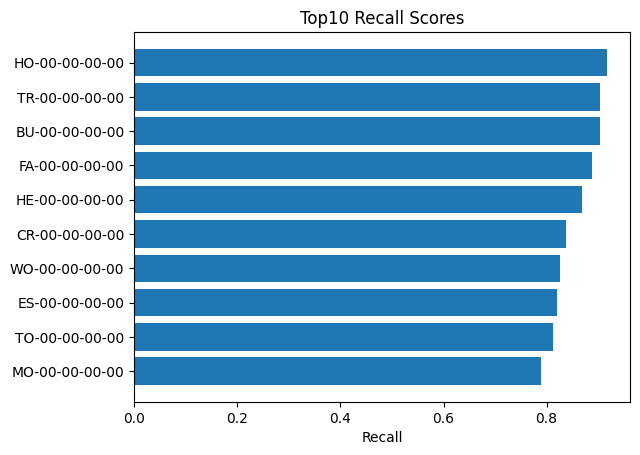

In [15]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

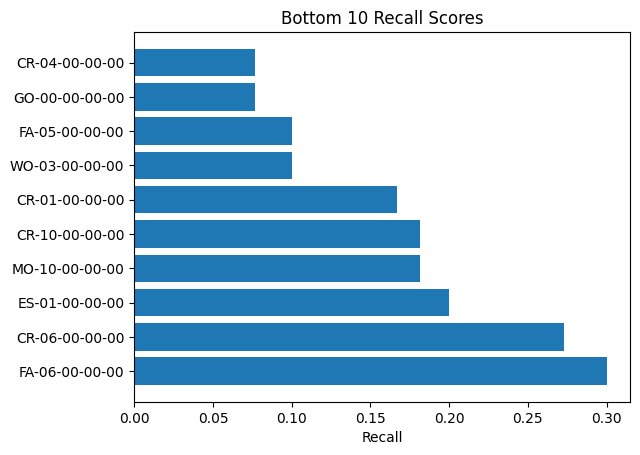

In [16]:


# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    62.96
1    90.32
2    78.30
3    83.77
4    16.67
5     7.69
6    27.27
7    18.18
8    66.67
9    82.05
10   20.00
11   30.77
12   88.80
13   10.00
14   30.00
15   63.41
16    7.69
17   86.89
18   91.64
19   67.65
20   66.67
21   77.78
22   78.96
23   33.33
24   46.15
25   18.18
26   31.82
27   81.30
28   90.38
29   68.18
30   58.62
31   41.18
32   60.00
33   74.19
34   82.69
35   10.00


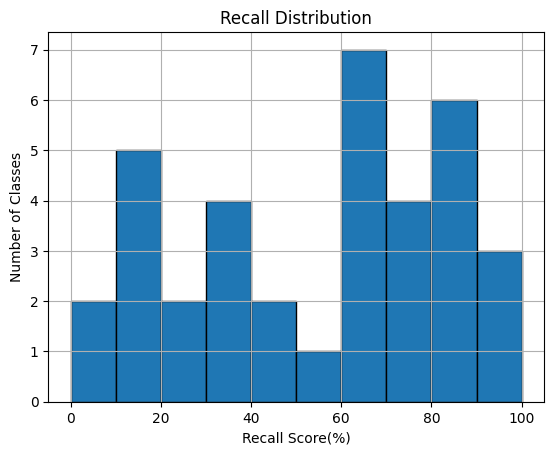

In [17]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.2030
1    0.1605
2    0.3084
3    0.3018
4    0.2167
5    0.2541
6    0.1300
7    0.1520
8    0.1214
9    0.2111
10   0.0903
11   0.2012
12   0.2557
13   0.1220
14   0.1435
15   0.3248
16   0.2269
17   0.1829
18   0.2186
19   0.2659
20   0.1828
21   0.1233
22   0.3723
23   0.1405
24   0.0781
25   0.1824
26   0.3655
27   0.3715
28   0.1934
29   0.1491
30   0.2079
31   0.1180
32   0.1366
33   0.1033
34   0.3209
35   0.2396


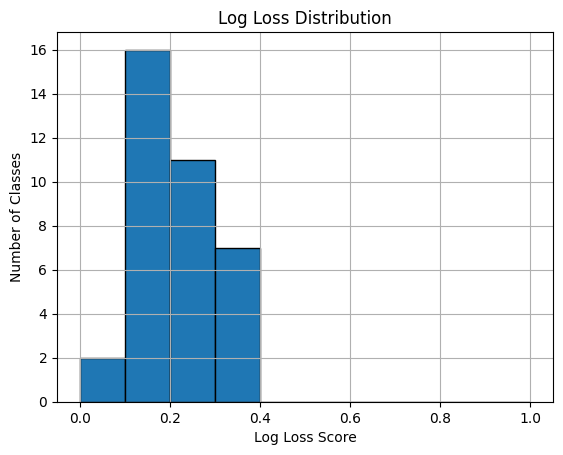

In [18]:
import pylab as pl

logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

## Brier Score Loss

    brierloss
0      0.0465
1      0.0448
2      0.0879
3      0.0910
4      0.0433
5      0.0547
6      0.0295
7      0.0293
8      0.0240
9      0.0611
10     0.0188
11     0.0423
12     0.0757
13     0.0243
14     0.0318
15     0.0961
16     0.0464
17     0.0499
18     0.0601
19     0.0679
20     0.0439
21     0.0289
22     0.1172
23     0.0256
24     0.0200
25     0.0371
26     0.0954
27     0.1152
28     0.0519
29     0.0354
30     0.0523
31     0.0275
32     0.0277
33     0.0236
34     0.0989
35     0.0499


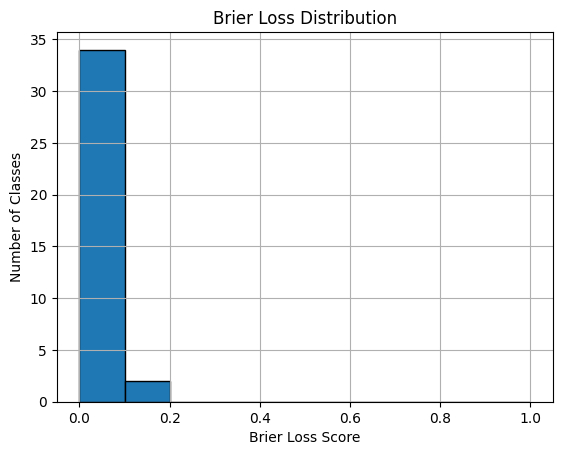

In [19]:

brierloss_dict = defaultdict()
for k,v in stat_dict.items():
    brierloss_dict[k] = v[6]

brierloss_list = []
for k,v in brierloss_dict.items():
    brierloss_list.append(v)
   
d = {'brierloss': brierloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Brier Loss Distribution")
pl.xlabel("Brier Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [20]:
#text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"
text = "I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car."
print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
c_logloss = defaultdict()

for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


I had my car parked at work and someone stole my car. I went to report my car stolen at the police station but I got a call later saying I can’t report it stolen because a title change occurred. I never sold my car, never signed anything. I feel completely powerless and violated. I honestly don’t know what to do. If I find out who stole my car I will most likely snap because I don’t know what else to do. This has never happened to me. What legal steps can I take? Edit: I can’t find the title. My sister was coming back home from the army and I intended on giving her the car when she arrived. I most likely left the title in the car.
CR-00-00-00-00 [1.] 0.7819
TO-00-00-00-00 [1.] 0.8202
TR-00-00-00-00 [1.] 0.9916
TR-01-00-00-00 [1.] 0.943
TR-02-00-00-00 [1.] 0.7068
TR-03-00-00-00 [1.] 0.7587
TR-04-00-00-00 [1.] 0.9994
